In [1]:
from pathlib import Path

ROOT = Path("../")
DATA = ROOT / "data"

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import shutil
from functools import partial

import numpy as np
import torch
from box import ConfigBox
from dvclive import Live
from dvclive.fastai import DVCLiveCallback
from fastai.data.all import Normalize, get_files
from fastai.metrics import DiceMulti
from fastai.vision.all import (Resize, SegmentationDataLoaders, aug_transforms,
                               imagenet_stats, models, unet_learner)
from ruamel.yaml import YAML
from PIL import Image

### Load data and split it into train/test

In [4]:
test_pct = 0.25

img_fpaths = get_files(DATA / "pool_data" / "images", extensions=".jpg")

train_data_dir = DATA / "train_data"
train_data_dir.mkdir(exist_ok=True)
test_data_dir = DATA / "test_data"
test_data_dir.mkdir(exist_ok=True)
for img_path in img_fpaths:
    msk_path = DATA / "pool_data" / "masks" / f"{img_path.stem}.png"
    if np.random.uniform() <= test_pct:
        shutil.copy(img_path, test_data_dir)
        shutil.copy(msk_path, test_data_dir)
    else:
        shutil.copy(img_path, train_data_dir)
        shutil.copy(msk_path, train_data_dir)

### Create a data loader

In [5]:
def get_mask_path(x, train_data_dir):
    return Path(train_data_dir) / f"{Path(x).stem}.png"

In [6]:
bs = 8
valid_pct = 0.20
img_size = 256

data_loader = SegmentationDataLoaders.from_label_func(
        path=train_data_dir,
        fnames=get_files(train_data_dir, extensions=".jpg"),
        label_func=partial(get_mask_path, train_data_dir=train_data_dir),
        codes=["not-pool", "pool"],
        bs=bs,
        valid_pct=valid_pct,
        item_tfms=Resize(img_size),
        batch_tfms=[
            *aug_transforms(size=img_size),
            Normalize.from_stats(*imagenet_stats),
        ],
    )

### Review a sample batch of data

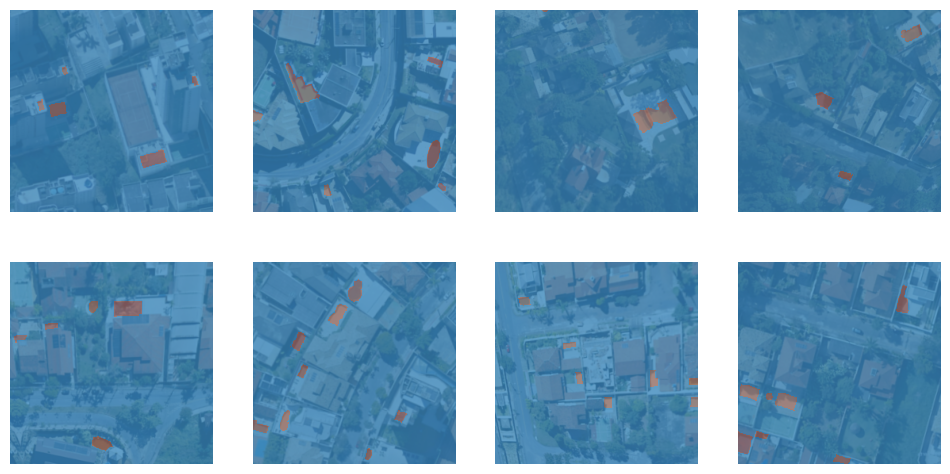

In [7]:
data_loader.show_batch(alpha=0.7)

### Train multiple models with different learning rates using `DVCLiveCallback`

In [8]:
def dice(mask_pred, mask_true, classes=[0, 1], eps=1e-6):
    dice_list = []
    for c in classes:
        y_true = mask_true == c
        y_pred = mask_pred == c
        intersection = 2.0 * np.sum(y_true * y_pred)
        dice = intersection / (np.sum(y_true) + np.sum(y_pred) + eps)
        dice_list.append(dice)
    return np.mean(dice_list)

In [9]:
train_arch = 'resnet18'

for base_lr in [0.001, 0.005, 0.01]:
    with Live(str(ROOT / "results" / "train"), save_dvc_exp=True) as live:
        live.log_param("train_arch", train_arch)
        fine_tune_args = {
            'epochs': 8,
            'base_lr': base_lr
        }
        live.log_params(fine_tune_args)

        learn = unet_learner(data_loader, 
                            arch=getattr(models, train_arch), 
                            metrics=DiceMulti)
        learn.fine_tune(
            **fine_tune_args,
            cbs=[DVCLiveCallback(live=live)])


        test_img_fpaths = get_files(DATA / "test_data", extensions=".jpg")
        test_dl = learn.dls.test_dl(test_img_fpaths)
        preds, _ = learn.get_preds(dl=test_dl)
        masks_pred = np.array(preds[:, 1, :] > 0.5, dtype=int)
        test_mask_fpaths = [
            get_mask_path(fpath, DATA / "test_data") for fpath in test_img_fpaths
        ]
        masks_true = [Image.open(mask_path) for mask_path in test_mask_fpaths]
        masks_true = [
            np.array(img.resize((img_size, img_size)), dtype=int) for img in masks_true
        ]
        dice_multi = 0.0
        for ii in range(len(masks_true)):
            mask_pred, mask_true = masks_pred[ii], masks_true[ii]
            dice_multi += dice(mask_true, mask_pred) / len(masks_true)
        live.summary["evaluate/dice_multi"] = dice_multi

epoch,train_loss,valid_loss,dice_multi,time
0,0.175995,0.093012,0.495926,00:02


epoch,train_loss,valid_loss,dice_multi,time
0,0.062374,0.065341,0.626571,00:01
1,0.050811,0.033541,0.739481,00:01
2,0.043004,0.026282,0.821868,00:01
3,0.038333,0.020736,0.889792,00:01
4,0.034535,0.023850,0.848748,00:01
5,0.031734,0.019356,0.903975,00:01
6,0.029154,0.020413,0.877915,00:01
7,0.027598,0.020454,0.877726,00:01


	results/train/report.html, results/train/params.yaml, results/train/metrics.json, results/train/dvc.yaml, results/train/plots/metrics/dice_multi.tsv, results/train/plots/metrics/eval/loss.tsv, results/train/plots/metrics/train/loss.tsv
	results/train/report.html, results/train/params.yaml, results/train/metrics.json, results/train/dvc.yaml, results/train/plots/metrics/dice_multi.tsv, results/train/plots/metrics/eval/loss.tsv, results/train/plots/metrics/train/loss.tsv


epoch,train_loss,valid_loss,dice_multi,time
0,2.562548,0.109084,0.495926,00:01


epoch,train_loss,valid_loss,dice_multi,time
0,0.112754,0.079241,0.495926,00:01
1,0.077694,0.041743,0.724098,00:01
2,0.100478,0.088181,0.584396,00:01
3,0.084445,0.031997,0.850328,00:01
4,0.070943,0.022643,0.892259,00:01
5,0.061214,0.021340,0.884432,00:01
6,0.054041,0.019882,0.895647,00:01
7,0.048221,0.019355,0.896903,00:01


	results/train/report.html, results/train/params.yaml, results/train/metrics.json, results/train/dvc.yaml, results/train/plots/metrics/dice_multi.tsv, results/train/plots/metrics/eval/loss.tsv, results/train/plots/metrics/train/loss.tsv
	results/train/report.html, results/train/params.yaml, results/train/metrics.json, results/train/dvc.yaml, results/train/plots/metrics/dice_multi.tsv, results/train/plots/metrics/eval/loss.tsv, results/train/plots/metrics/train/loss.tsv


epoch,train_loss,valid_loss,dice_multi,time
0,4.409758,0.337393,0.495926,00:01


epoch,train_loss,valid_loss,dice_multi,time
0,0.207570,0.079014,0.495926,00:01
1,0.137224,0.074637,0.530160,00:01
2,0.103880,0.026666,0.872907,00:01
3,0.082248,0.031445,0.845663,00:01
4,0.068189,0.019152,0.896179,00:01
5,0.058192,0.021096,0.868080,00:01
6,0.050810,0.018920,0.890276,00:01
7,0.045114,0.018467,0.894095,00:01


	results/train/report.html, results/train/params.yaml, results/train/metrics.json, results/train/dvc.yaml, results/train/plots/metrics/dice_multi.tsv, results/train/plots/metrics/eval/loss.tsv, results/train/plots/metrics/train/loss.tsv
	results/train/report.html, results/train/params.yaml, results/train/metrics.json, results/train/dvc.yaml, results/train/plots/metrics/dice_multi.tsv, results/train/plots/metrics/eval/loss.tsv, results/train/plots/metrics/train/loss.tsv


In [10]:
# Compare experiments
!dvc exp show --only-changed

 ──────────────────────────────────────────────────────────────────────────────────────────────────────── 
  Experiment                 Created    train.loss   eval.loss   dice_multi   step   evaluate/dice_multi  
 ──────────────────────────────────────────────────────────────────────────────────────────────────────── 
  workspace                  -            0.045114    0.018467       0.8941      8               0.89467  
  main                       02:25 PM            -           -            -      -                     -  
  ├── f160777 [caped-jive]   02:29 PM     0.045114    0.018467       0.8941      8               0.89467  
  ├── ec8ba2b [lated-roam]   02:28 PM     0.048221    0.019355       0.8969      8               0.89968  
  └── b1d4eed [kinky-plum]   02:28 PM     0.027598    0.020454      0.87773      8               0.88518  
 ──────────────────────────────────────────────────────────────────────────────────────────────────────── 


### Review sample preditions vs ground truth

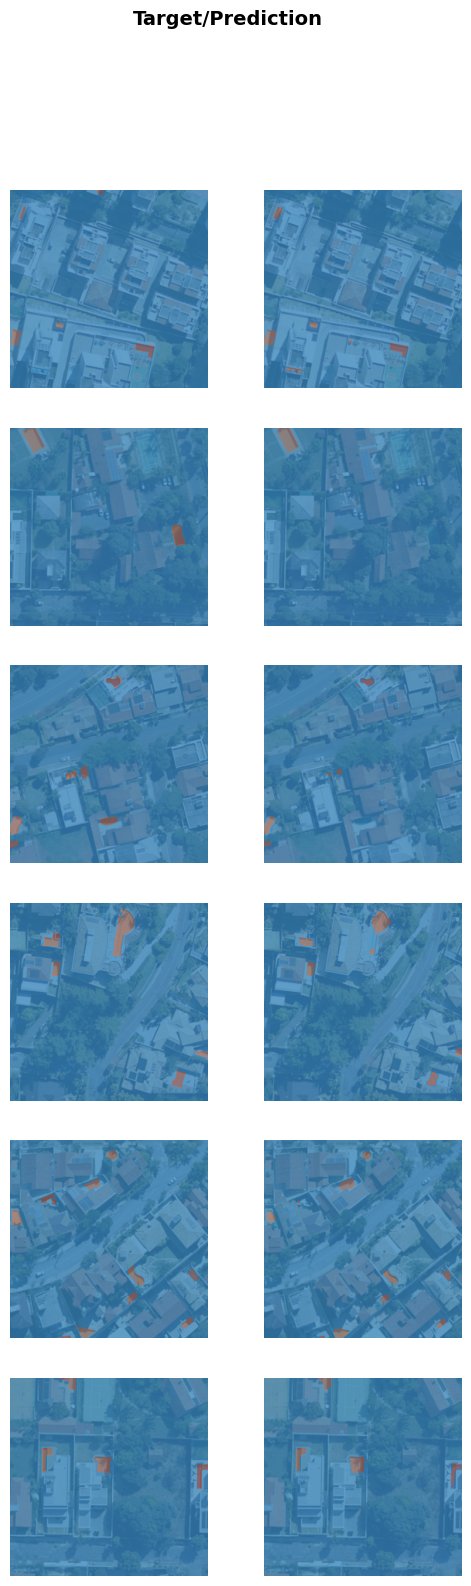

In [11]:
learn.show_results(max_n=6, alpha=0.7)

### Review instances where loss function values are the highest (i.e. model is likely to be wrong)

In [12]:
from fastai.vision.all import SegmentationInterpretation

interp = SegmentationInterpretation.from_learner(learn)

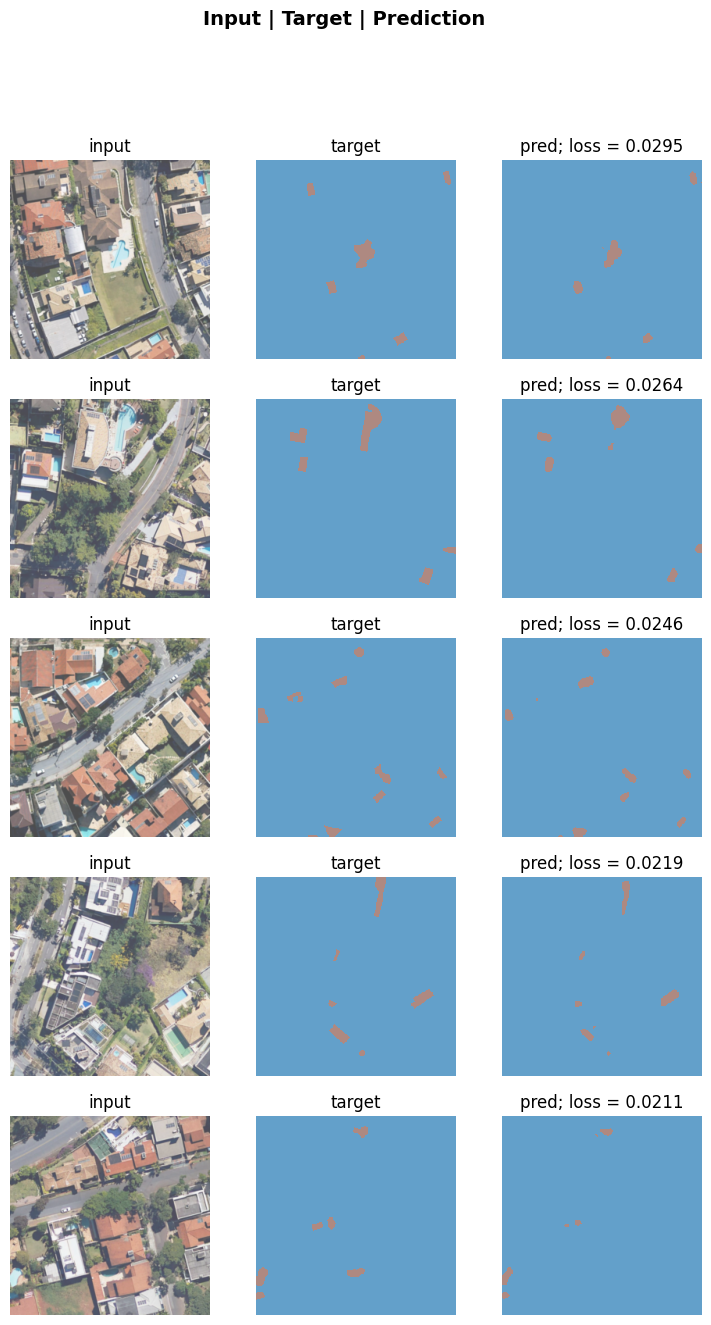

In [13]:
interp.plot_top_losses(k=5, alpha=0.7)